# CNNs for Image Classifocation with Pytorch

In [ ]:
! pip install --quiet "setuptools==59.5.0" "ipython[notebook]" "torchmetrics>=0.7" "torchvision" "seaborn" "torchviz" "pytorch-lightning"
! rm -rf ./logs/

In [ ]:
from IPython.display import Image
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, random_split
from torch.utils.tensorboard.writer import SummaryWriter

from torchvision import datasets
from torchvision.transforms import ToTensor, Normalize, Compose

from torchmetrics.classification import MulticlassAccuracy

from torchviz import make_dot

from torchsummary import summary

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.utilities.model_summary.model_summary import ModelSummary

import numpy as np
import matplotlib.pyplot as plt
import os
import datetime
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm

from google.colab import drive

%load_ext tensorboard

drive.mount('/content/drive/')

writer = SummaryWriter()

In [ ]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

# I. First step: Simple Convolutional Neural Network




### Collecting and loading the data

In [ ]:
# Download training data from open datasets
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform = Compose([
    ToTensor()])
)

# Download test data from open datasets
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=Compose([
    ToTensor()])
)

# Display information about the data
print( 'Train data: ', training_data)
print( 'Test data: ', test_data)

In [ ]:
# Split training data into test and validation set
train_dataset, val_dataset = torch.utils.data.random_split(training_data, [0.8,0.2])

# Create data loaders
batch_size = 128

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

# Check our data's dimensions
for X, y in train_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.size()}")
    print(f"Shape of y: {y.size()}")
    break

### Exploring the data

In [ ]:
# Display a few datapoints
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## Building and training the model with Pytorch

### Architecture

In [ ]:
# Our class extends the nn.Module class
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()

        # Feature extraction stack
        self.conv_stack = nn.Sequential(
            nn.Conv2d(1,6,(5,5),padding=2),
            nn.Sigmoid(),
            nn.AvgPool2d((2,2),stride=2),
            nn.Conv2d(6,16,(5,5)),
            nn.Sigmoid(),
            nn.AvgPool2d((2,2),stride=2),
        )

        # Classification stack
        self.dense_stack = nn.Sequential(
            nn.LazyLinear(120),
            nn.Sigmoid(),
            nn.Linear(120,84),
            nn.Sigmoid(),
            nn.Linear(84,10),
            nn.Softmax()
        )

    def forward(self, x):
        x = self.conv_stack(x)
        x = self.flatten(x)
        logits = self.dense_stack(x)

        return logits

model = LeNet()


print(model)

In [ ]:
# Let us plot the model's graph and each layer's shapes
# The torchviz library requires us to pass a dummy batch to the model's forward()
batch = next(iter(train_dataloader))
yhat = model(batch[0])

make_dot(yhat, params=dict(list(model.named_parameters()))).render("model_torchviz", format="png")

In [ ]:
# Display information about our model's layers
summary(model.to(device), (1,28,28))

### Training

In [ ]:
# Create the training function
def train(dataloader, model, metric, loss_fn, optimizer, epoch, device):
    size = len(dataloader.dataset)
    outputs_list = []

    # Iterate over all batches. pbar:= allows us to display our training's progression with a progress bar.
    for batch, (X, y) in (pbar:= tqdm(enumerate(dataloader), total=len(dataloader))):
        # Need to convert X and y dtype to implement VGG16 later
        X = X.to(device).float()
        y = y.to(device).long()

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Add batch lostt to tensorboard's writer
        writer.add_scalar("Loss/train", loss, batch)

        # Collect batch metrics in a list
        outputs_list.append({"loss": loss, "preds": pred, "labels": y})

        # Update progress bar
        pbar.set_description(desc=f"Train - Loss:{loss:.2f}")

    # Join batch metrics and compute accuracy
    preds = torch.cat([x["preds"] for x in outputs_list]).detach().cpu()
    labels = torch.cat([x["labels"] for x in outputs_list]).detach().cpu()
    loss = torch.stack([x["loss"] for x in outputs_list]).mean()
    acc = metric(preds, labels)
    
    # Log everything to tensorboard's writer
    writer.add_scalar(f"train/loss", loss, epoch)
    writer.add_scalar(f"train/acc", acc, epoch)

    print(f"Train - Loss: {loss:.2f}, Acc: {acc}")

In [ ]:
def test(dataloader, model, metric, loss_fn, epoch, device):
    outputs_list = []
    size = len(dataloader.dataset)
    num_batches = len(dataloader)

    # We freeze the gradients at evaluation
    with torch.no_grad():
        for batch, (X, y) in (pbar:= tqdm(enumerate(dataloader), total=len(dataloader))):
            X = X.to(device).float()
            y = y.to(device).long()
            pred = model(X)
            test_loss = loss_fn(pred, y)
            outputs_list.append({"loss": test_loss, "preds": pred, "labels": y})

            pbar.set_description(desc=f"Val - Loss:{test_loss:.2f}")

    preds = torch.cat([x["preds"] for x in outputs_list]).detach().cpu()
    labels = torch.cat([x["labels"] for x in outputs_list]).detach().cpu()
    loss = torch.stack([x["loss"] for x in outputs_list]).mean()
    acc = metric(preds, labels)
    
    writer.add_scalar(f"val/loss", loss, epoch)
    writer.add_scalar(f"val/acc", acc, epoch)    

    print(f"Val - Loss: {loss:.2f}, Acc: {acc}")
    
    # We return the accuracy to implement the Callback
    return acc

In [ ]:
learning_rate = 1e-3

metric = MulticlassAccuracy(num_classes=10)
loss_fn = nn.CrossEntropyLoss()
model = LeNet().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
epochs = 20
best_acc = 0
counter = 0
patience = 5
delta = 1e-4
for t in range(epochs):
    print(f"-------------------------------\nEpoch {t+1}\n-------------------------------")

    model.train()
    train(train_dataloader, model, metric, loss_fn, optimizer, t, device)
    
    model.eval()
    val_acc = test(val_dataloader, model, metric, loss_fn, t, device)

    # Callback: if the model does not improve significantly after some eopchs, stop training to prevent overfitting
    if (val_acc > best_acc and val_acc-best_acc >= delta):
        best_acc = val_acc
        counter = 0
    elif (val_acc > best_acc and val_acc-best_acc < delta):
        best_acc = val_acc
        counter += 1
    else:
        counter +=1

    if counter >= patience:
        print(f"No significant improvement after {patience} epochs, stopping early.")
        break

print("Done!")
writer.flush()

### Results

In [ ]:
%tensorboard --logdir=runs

In [ ]:
# Evaluate the model on the test set
model.eval()
outputs_list = []
with torch.no_grad():
    for (X, y) in iter(test_dataloader):
        X = X.to(device).float()
        y = y.to(device).long()
        pred = model(X)
        outputs_list.append({"preds": pred, "labels": y})

preds = torch.cat([x["preds"] for x in outputs_list]).argmax(axis=1).detach().cpu()
labels = torch.cat([x["labels"] for x in outputs_list]).detach().cpu()

acc = metric(preds, labels)

print("Accuracy on test set: {0}".format(acc))

## Building and training the model with Pytorch Lighting

In [ ]:
# Flatten layer
flatten = nn.Flatten()

# Feature extraction stack
conv_stack = nn.Sequential(
    nn.Conv2d(1,6,(5,5),padding=2),
    nn.Sigmoid(),
    nn.AvgPool2d((2,2),stride=2),
    nn.Conv2d(6,16,(5,5)),
    nn.Sigmoid(),
    nn.AvgPool2d((2,2),stride=2),
)

# Classification stack
dense_stack = nn.Sequential(
    nn.LazyLinear(120),
    nn.Sigmoid(),
    nn.Linear(120,84),
    nn.Sigmoid(),
    nn.Linear(84,10),
    nn.Softmax(dim=1)
)

In [ ]:
class LitAutoLeNet(pl.LightningModule):
    def __init__(self, flatten, conv_stack, dense_stack, loss, metric):
        super().__init__()
        self.flatten = flatten
        self.conv_stack = conv_stack
        self.dense_stack = dense_stack
        self.loss_fn = loss
        self.metric_fn = metric

    def training_step(self, train_batch, batch_idx):
        # training_step defines the train loop.
        # it is independent of forward
        x, y = train_batch
        pred = self.conv_stack(x)
        pred = self.flatten(pred)
        pred = self.dense_stack(pred)

        loss = self.loss_fn(pred, y)
        acc = self.metric_fn(pred, y)
        
        # Logging to TensorBoard
        values = {"train_loss": loss, "train_acc": acc}
        self.log_dict(values, on_epoch = True)
        return loss

    def validation_step(self, val_batch, batch_idx):
        # validation_step defines the validation loop.
        x, y = val_batch

        pred = self.conv_stack(x)
        pred = self.flatten(pred)
        pred = self.dense_stack(pred)

        loss = self.loss_fn(pred, y)
        acc = self.metric_fn(pred, y)

        values = {"val_loss": loss, "val_acc": acc}
        self.log_dict(values, on_epoch = True, prog_bar = True)

    def test_step(self, test_batch, batch_idx):
        # test_step defines the test loop. 
        x, y = test_batch

        pred = self.conv_stack(x)
        pred = self.flatten(pred)
        pred = self.dense_stack(pred)

        loss = self.loss_fn(pred, y)
        acc = self.metric_fn(pred, y)

        self.log("test_acc", acc)

        return acc

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [ ]:
# Define metric and loss function
metric = MulticlassAccuracy(num_classes=10)
loss_fn = nn.CrossEntropyLoss()

# Initialize the model
model = LitAutoLeNet(flatten, conv_stack, dense_stack, loss_fn, metric)

# Wrap the model in a trainer object and instantiate an early stopping 
early_stopping = EarlyStopping('val_loss')
trainer = pl.Trainer(gpus=1, callbacks=[early_stopping], max_epochs=50)

In [ ]:
trainer.fit(model, train_dataloader, val_dataloader)

### Results

In [ ]:
#Plot the curve of the metrics during training
%tensorboard --logdir=lightning_logs

In [ ]:
trainer.test(ckpt_path="best", dataloaders=test_dataloader)

# II. Second step: Simple Convolutionnal Neural Network on more complex data.

### Collecting and loading the data

In [54]:
# We need to create a custom dataset that extends the Dataset class
class MedMNISTDataset(Dataset):
    def __init__(self, label_array, img_array, transform=None, target_transform=None):

        # Load the npy arrays where our data is stored
        self.img_labels = np.load(label_array)
        self.img_array = np.load(img_array)

        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):

        # Pair each image with its label and apply transformations
        image = self.img_array[idx]
        label = self.img_labels[idx, 0]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [55]:
# preprocessing
data_transform = Compose([
    ToTensor(),
])

# load the data
xTrain='/content/drive/MyDrive/Colab Notebooks/Computer Vision/Lab3/pathmnist/train_images.npy'
xVal='/content/drive/MyDrive/Colab Notebooks/Computer Vision/Lab3/pathmnist/val_images.npy'
xTest='/content/drive/MyDrive/Colab Notebooks/Computer Vision/Lab3/pathmnist/test_images.npy'

yTrain='/content/drive/MyDrive/Colab Notebooks/Computer Vision/Lab3/pathmnist/train_labels.npy'
yVal='/content/drive/MyDrive/Colab Notebooks/Computer Vision/Lab3/pathmnist/val_labels.npy'
yTest='/content/drive/MyDrive/Colab Notebooks/Computer Vision/Lab3/pathmnist/test_labels.npy'


# Wrap the data into datasets
train_dataset = MedMNISTDataset(yTrain,xTrain, data_transform)
val_dataset = MedMNISTDataset(yVal,xVal, data_transform)
test_dataset = MedMNISTDataset(yTest,xTest, data_transform)



batch_size = 128
# Wrap datasets into dataloaders
train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


### Exploring the data

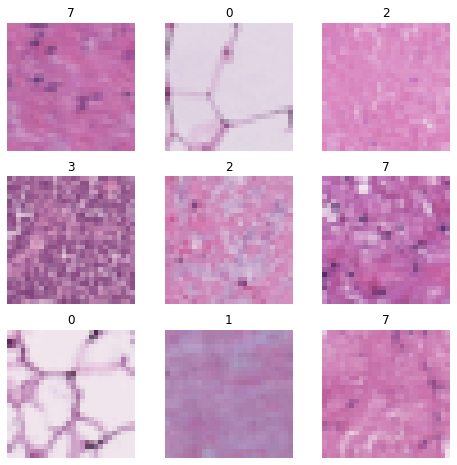

In [74]:
# Display a few datapoints
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    img = img.permute(1, 2, 0)
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze())
plt.show()

## Building and training the model with Pytorch

### Architecture

In [ ]:
class LeNetMed(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.conv_stack = nn.Sequential(
            nn.Conv2d(3,6,(5,5),padding=2),
            nn.Sigmoid(),
            nn.AvgPool2d((2,2),stride=2),
            nn.Conv2d(6,16,(5,5)),
            nn.Sigmoid(),
            nn.AvgPool2d((2,2),stride=2),
        )
        self.dense_stack = nn.Sequential(
            nn.LazyLinear(120),
            nn.Sigmoid(),
            nn.Linear(120,84),
            nn.Sigmoid(),
            nn.Linear(84,9),
            nn.Softmax()
        )

    def forward(self, x):
        x = self.conv_stack(x)
        x = self.flatten(x)
        logits = self.dense_stack(x)

        return logits

model_med = LeNetMed()
print(model_med)

In [ ]:
batch = next(iter(train_dataloader))
yhat = model_med(batch[0])

make_dot(yhat, params=dict(list(model_med.named_parameters()))).render("model_med_torchviz", format="png")

### Training

In [ ]:
learning_rate = 1e-3

metric = MulticlassAccuracy(num_classes=9)
loss_fn = nn.CrossEntropyLoss()
model_med = LeNetMed().to(device)

optimizer = torch.optim.AdamW(model_med.parameters(), lr=learning_rate)
epochs = 5
best_acc = 0
counter = 0
patience = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model_med, metric, loss_fn, optimizer, t, device)
    val_acc = test(val_dataloader, model_med, metric, loss_fn, t, device)
    if (val_acc > best_acc and val_acc-best_acc >= 1e-4):
        best_acc = val_acc
        counter = 0
    elif (val_acc > best_acc and val_acc-best_acc < 1e-4):
        best_acc = val_acc
        counter += 1
    else:
        counter +=1

    if counter >= patience:
        print(f"No significant improvement after {patience} epochs, stopping early.")
        break
print("Done!")
writer.flush()

### Results

In [ ]:
#Plot the curve of the metrics during training
%tensorboard --logdir=runs 

In [ ]:
model.eval()
outputs_list = []
with torch.no_grad():
    for (X, y) in iter(test_dataloader):
        X = X.to(device).float()
        y = y.to(device).long()
        pred = model(X)
        outputs_list.append({"preds": pred, "labels": y})

preds = torch.cat([x["preds"] for x in outputs_list]).argmax(axis=1).detach().cpu()
labels = torch.cat([x["labels"] for x in outputs_list]).detach().cpu()

acc = metric(preds, labels)

print("Accuracy on test set: {0}".format(acc))

## Building and training the model with Pytorch Lightning

In [ ]:
# Flatten layer
flatten = nn.Flatten()

# Feature extraction stack
conv_stack = nn.Sequential(
    nn.Conv2d(3,6,(5,5),padding=2),
    nn.Sigmoid(),
    nn.Dropout(0.15),
    nn.AvgPool2d((2,2),stride=2),
    nn.Conv2d(6,16,(5,5)),
    nn.Sigmoid(),
    nn.Dropout(0.15),
    nn.AvgPool2d((2,2),stride=2),
)

# Classification stack
dense_stack = nn.Sequential(
    nn.LazyLinear(120),
    nn.Sigmoid(),
    nn.Linear(120,84),
    nn.Sigmoid(),
    nn.Linear(84,9),
    nn.Softmax(dim=1)
)

In [ ]:
class LitAutoLeNetMed(pl.LightningModule):
    def __init__(self, flatten, conv_stack, dense_stack, loss, metric):
        super().__init__()
        self.flatten = flatten
        self.conv_stack = conv_stack
        self.dense_stack = dense_stack
        self.loss_fn = loss
        self.metric_fn = metric

    def training_step(self, train_batch, batch_idx):
        # training_step defines the train loop.
        # it is independent of forward
        x, y = train_batch

        pred = self.conv_stack(x)
        pred = self.flatten(pred)
        pred = self.dense_stack(pred)

        loss = self.loss_fn(pred, y)
        acc = self.metric_fn(pred, y)
        
        # Logging to TensorBoard
        values = {"train_loss": loss, "train_acc": acc}
        self.log_dict(values, on_epoch = True)
        
        return loss

    def validation_step(self, val_batch, batch_idx):
        # validation_step defines the validation loop.
        x, y = val_batch

        pred = self.conv_stack(x)
        pred = self.flatten(pred)
        pred = self.dense_stack(pred)

        loss = self.loss_fn(pred, y)
        acc = self.metric_fn(pred, y)

        values = {"val_loss": loss, "val_acc": acc}
        self.log_dict(values, on_epoch = True, prog_bar = True)

    def test_step(self, test_batch, batch_idx):
        # test_step defines the test loop.
        x, y = test_batch

        pred = self.conv_stack(x)
        pred = self.flatten(pred)
        pred = self.dense_stack(pred)

        loss = self.loss_fn(pred, y)
        acc = self.metric_fn(pred, y)

        self.log("test_acc", acc)
        return acc

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [ ]:
# Define metric and loss function
metric = MulticlassAccuracy(num_classes=9)
loss_fn = nn.CrossEntropyLoss()

# Initialize the model
model = LitAutoLeNetMed(flatten, conv_stack, dense_stack, loss_fn, metric)

# Wrap the model in a trainer object and instantiate an early stopping 
early_stopping = EarlyStopping('val_loss')
trainer = pl.Trainer(gpus=1, callbacks=[early_stopping], max_epochs=50)

In [ ]:
trainer.fit(model, train_dataloader, val_dataloader)

### Results

In [ ]:
#Plot the curve of the metrics during training
%tensorboard --logdir=lightning_logs

In [ ]:
trainer.test(ckpt_path="best", dataloaders=test_dataloader)

# III. Third step: Transfer Learning

In [82]:
from torchvision.models import vgg16, VGG16_Weights
weights=VGG16_Weights.DEFAULT
preprocess = weights.transforms()

from PIL import Image

import glob

### Collecting and loading the data

In [ ]:
# WARNING: do not run this cell now. It is very time consuming. Run the next one and come back here if you have time later.
datasetRoot='/content/drive/MyDrive/Colab Notebooks/Computer Vision/Lab3/animal-10/raw-img/'
classes = ['mucca', 'elefante', 'gatto', 'cavallo', 'scoiattolo', 'ragno', 'pecora', 'farfalla', 'gallina', 'cane']
nbClasses = len(classes)

#training data

rootTrain = datasetRoot+'train/'
classLabel = 0

xTrain = np.empty(shape=(0,224,224,3))
yTrain = []
first = True
for cl in tqdm(classes):
    listImages = glob.glob(rootTrain+cl+'/*')
    yTrain += [classLabel]*100
    for pathImg in tqdm(listImages[:100]):
        img = Image.open(pathImg).resize((224, 224))
        im = preprocess(img)
        im = np.array(img)
        im = np.expand_dims(im, axis=0)
        xTrain = np.vstack([xTrain, im])
    classLabel += 1
print(len(yTrain))
print(xTrain.shape)


In [96]:
# Load the training data

datasetRoot='/content/drive/MyDrive/Colab Notebooks/Computer Vision/Lab3/animal-10/raw-img/'
classes = ['mucca', 'gatto']
nbClasses = len(classes)

rootTrain = datasetRoot+'train/'
classLabel = 0

xTrain = np.empty(shape=(0,224,224,3))
yTrain = []
first = True
for cl in tqdm(classes):
    listImages = glob.glob(rootTrain+cl+'/*')
    yTrain += [classLabel]*500
    for pathImg in tqdm(listImages[:500]):
        img = Image.open(pathImg).resize((224, 224))
        im = preprocess(img)
        im = np.array(img, dtype = "float32")
        im = np.expand_dims(im, axis=0)
        xTrain = np.vstack([xTrain, im])
    classLabel += 1
print(len(yTrain))
print(xTrain.shape)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

10
(10, 224, 224, 3)


In [ ]:
# Load the test data

datasetRoot='/content/drive/MyDrive/Colab Notebooks/Computer Vision/Lab3/animal-10/raw-img/'

rootTest = datasetRoot+'test/'
classLabel = 0

xTest = np.empty(shape=(0,224,224,3))
yTest = []

for cl in tqdm(classes):
    listImages = glob.glob(rootTest+cl+'/*')
    yTest += [classLabel]*len(listImages)
    for pathImg in tqdm(listImages):
        img = Image.open(pathImg).resize((224, 224))
        im = preprocess(img)
        im = np.array(img, dtype = "float32")
        im = np.expand_dims(im, axis=0)
        xTest = np.vstack([xTest, im])
    classLabel += 1
print(len(yTest))
print(xTest.shape)

In [ ]:
class AnimalDataset(Dataset):
    def __init__(self, label_array, img_array):
        self.img_labels = label_array
        self.img_array = img_array

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        image = torch.tensor(self.img_array[idx].transpose(2, 0, 1), dtype = torch.float)
        label = torch.tensor(self.img_labels[idx], dtype = torch.float)
        return image, label

In [97]:
train_val_dataset = AnimalDataset(yTrain,xTrain)
test_dataset = AnimalDataset(yTest, xTest)

train_dataset, val_dataset = random_split(train_val_dataset, [0.8, 0.2])

batch_size = 64

train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

### Exploring the data

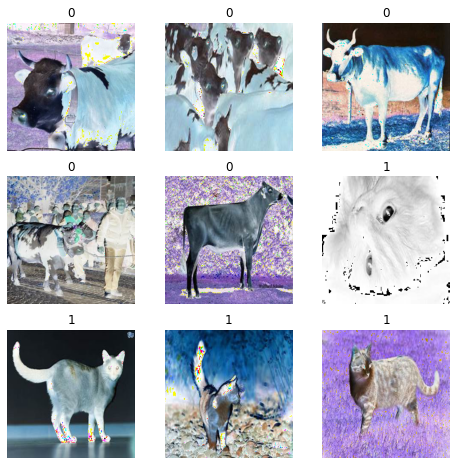

In [98]:
# Display a few datapoints
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    img, label = xTrain[i-1], yTrain[i-1]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow((img *255).astype(np.uint8))
plt.show()

## Pre-trained model with Pytorch

### Architecture

In [ ]:
# Load pre-trained VGG16 model
vgg16_model = vgg16(weights = VGG16_Weights.DEFAULT)

# Customize pooling and classifier layers of the model
vgg16_model.avgpool = nn.AdaptiveAvgPool2d((7, 7))

vgg16_model.classifier = nn.Sequential(
    nn.Linear(in_features=512*7*7, out_features=1024, bias=True),
    nn.ReLU(),
    nn.Linear(in_features=1024, out_features=2, bias=True),
    nn.Softmax(),
  )

# Freeze all layers except for the classifier's
for child in list(vgg16_model.children())[:-1]:
    for param in list(child.parameters()):
        param.requires_grad = False

vgg16_classifier_model = vgg16_model

print(vgg16_classifier_model)

In [ ]:
summary(vgg16_classifier_model.to(device), (3,224,224))

In [ ]:
## Let us plot the model's graph and each layer's shapes
batch = list(train_dataloader)[0]
yhat = vgg16_classifier_model(batch[0].to(device))

make_dot(yhat, params=dict(list(vgg16_classifier_model.named_parameters()))).render("model_animal_torchviz", format="png")

In [ ]:
CUDA_LAUNCH_BLOCKING=1.

### Training

In [ ]:
learning_rate = 1e-2

metric = MulticlassAccuracy(num_classes=2)
loss_fn = nn.CrossEntropyLoss()

model = vgg16_classifier_model.to(device)

optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
epochs = 20
best_acc = 0
counter = 0
patience = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")

    model.train()
    train(train_dataloader, model, metric, loss_fn, optimizer, t, device)

    model.eval()
    val_acc = test(val_dataloader, model, metric, loss_fn, t, device)
    if (val_acc > best_acc and val_acc-best_acc >= 1e-4):
        best_acc = val_acc
        counter = 0
    elif (val_acc > best_acc and val_acc-best_acc < 1e-4):
        best_acc = val_acc
        counter += 1
    else:
        counter +=1

    if counter >= patience and best_acc >= val_acc:
        print(f"No significant improvement after {patience} epochs, stopping early.")
        break
print("Done!")
writer.flush()

### Results

In [ ]:
%tensorboard --logdir=runs

## Pre-trained model with Lightning

In [ ]:
class AnimalsClassifier(pl.LightningModule):
    def __init__(self, loss_fn, metric_fn):
        super().__init__()
        # init the pretrained LightningModule
        self.feature_extractor =  vgg16(weights="DEFAULT").features

        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=512, out_features=1024, bias=True),
            nn.ReLU(),
            nn.Linear(in_features=1024, out_features=2, bias=True),
            nn.Softmax(dim=1),
        )

        self.loss_fn = loss_fn
        self.metric_fn = metric_fn

    def forward(self, x):
        representations = self.feature_extractor(x)
        x = self.global_pool(representations)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        return logits

    def training_step(self, train_batch, batch_idx):
        # training_step defines the train loop.
        # it is independent of forward
        x, y = train_batch
        y=y.to(self.device, dtype=torch.long)


        pred = self.feature_extractor(x)
        pred = self.global_pool(pred)
        preds = self.classifier(pred)

        loss = self.loss_fn(preds, y)
        acc = self.metric_fn(preds, y)
        
        # Logging to TensorBoard (if installed) by default
        values = {"train_loss": loss, "train_acc": acc}
        self.log_dict(values, on_epoch = True)
        
        return loss

    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        y=y.to(self.device, dtype=torch.long)

        pred = self.feature_extractor(x)
        pred = self.global_pool(pred)
        preds = self.classifier(pred)

        loss = self.loss_fn(preds, y)
        acc = self.metric_fn(preds, y)

        values = {"val_loss": loss, "val_acc": acc}
        self.log_dict(values, on_epoch = True, prog_bar = True)

    def test_step(self, test_batch, batch_idx):
        x, y = test_batch
        y=y.to(self.device, dtype=torch.long)


        pred = self.feature_extractor(x)
        pred = self.global_pool(pred)
        preds = self.classifier(pred)

        loss = self.loss_fn(preds, y)
        acc = self.metric_fn(preds, y)

        self.log("test_acc", acc)

        return acc

    def configure_optimizers(self):
        optimizer = torch.optim.RMSprop(self.parameters(), lr=1e-2)
        return optimizer

In [ ]:
metric = MulticlassAccuracy(num_classes=2)
loss_fn = nn.CrossEntropyLoss()

model = AnimalsClassifier(loss_fn, metric)

early_stopping = EarlyStopping('val_loss')
trainer = pl.Trainer(
    gpus=1, 
    callbacks=[early_stopping], 
    max_epochs=50)

In [ ]:
for child in iter(model.feature_extractor.children()):
    for param in iter(child.parameters()):
        param.requires_grad=False

In [ ]:
ModelSummary(model,max_depth=-1) 

In [ ]:
trainer.fit(model, train_dataloader, val_dataloader)

### Results

In [ ]:
#Plot the curve of the metrics during training
%tensorboard --logdir=lightning_logs

In [ ]:
trainer.test(ckpt_path="best", dataloaders=test_dataloader)

## Fine-tune the network with Pytorch

In [ ]:
# Let us check all the named parameters in the model
i=0
for name, param in model.features.named_parameters():
    i+=1
    print(i,name)

In [ ]:
# Unfreeze all layers starting from the last convolutional layer

for param in list(vgg16_classifier_model.features.named_parameters())[-2:]:
    param[1].requires_grad = True

In [ ]:
# We use a smaller learning rate to fine-tune the model
learning_rate = 1e-4

metric = MulticlassAccuracy(num_classes=2)
loss_fn = nn.CrossEntropyLoss()
model = vgg16_classifier_model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
epochs = 20
best_acc = 0
counter = 0
patience = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")

    model.train()
    train(train_dataloader, model, metric, loss_fn, optimizer, t, device)

    model.eval()
    val_acc = test(test_dataloader, model, metric, loss_fn, t, device)
    if (val_acc > best_acc and val_acc-best_acc >= 1e-4):
        best_acc = val_acc
        counter = 0
    elif (val_acc > best_acc and val_acc-best_acc < 1e-4):
        best_acc = val_acc
        counter += 1
    else:
        counter +=1

    if counter >= patience and best_acc >= val_acc:
        print(f"No significant improvement after {patience} epochs, stopping early.")
        break
print("Done!")
writer.flush()

### Results

In [ ]:
#TO DO: Plot the curves of the metrics
%tensorboard --logdir=runs

In [ ]:
# Let us compute the confusion matrix
outputs_list = []
with torch.no_grad():
    for (X, y) in list(test_dataloader):
        X = X.to(device).float()
        y = y.to(device).long()
        pred = model(X)
        test_loss = loss_fn(pred, y)
        # correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        outputs_list.append({"preds": pred})

preds = torch.cat([x["preds"] for x in outputs_list]).detach().cpu()

y_classes = preds.argmax(axis=-1)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true = yTest, y_pred = y_classes)
print(cm)

In [ ]:
# Nicer Display:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(cm)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
plt.show()

## Fine tune network with Pytorch Lightning

In [ ]:
metric = MulticlassAccuracy(num_classes=2)
loss_fn = nn.CrossEntropyLoss()

model = AnimalsClassifier(loss_fn, metric)

early_stopping = EarlyStopping('val_loss')
trainer = pl.Trainer(
    gpus=1, 
    callbacks=[early_stopping], 
    max_epochs=50)

In [ ]:
for child in list(model.feature_extractor.children())[:-3]:
    for param in iter(child.parameters()):
        param.requires_grad=False

In [ ]:
ModelSummary(model,max_depth=-1) 

In [ ]:
trainer.fit(model, train_dataloader, val_dataloader)

### Results

In [ ]:
#Plot the curve of the metrics during training
%tensorboard --logdir=lightning_logs

In [ ]:
trainer.test(ckpt_path="best", dataloaders=test_dataloader)